# ETF Top Performer Analyzer

- Author: Team(Dashboard) - Ken Lee, Albert Peyton, Rabia Talib, Miglu Li | Special Thanks to our TA, Ms. Alfia Nova for her great guidance and mentoing. 
- Lastes Update: 2021.11.14
- Project objective: Create our own ETF Portfolio consisting of the top performing stocks found in the set of high ranking ETFs given by the U.S.News & World Report

In [1]:
# Import Modules
import pandas as pd
import os
import json
import requests
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import sqlalchemy as sql
from datetime import date
import logging
from dateutil.relativedelta import relativedelta
import numpy as np
# Our 3 ETF Libraries - ETFHistoryDownload(hist), ETFStockAnalytics(Analytic), ETFPerformanceForecast(Perf)
import ETFHistoryDownload as hist
import ETFStockAnalytics as analytic
import ETFPerformanceForecast as perf
from MCForecastTools import MCSimulation
import datetime

# STEP1. IMPORT ETF AND CONSTITUENTS LIST INTO SQL DB 
Import INDEX and USNEWS ETF Benchmarks and holding names (constituents) INTO SQL Tables from CSVs

In [2]:
#CSV Data Path
etf_list_path = Path('./Resources/etf_list.csv')
etf_constituents_path = Path('./Resources/etf_holdings.csv')
etf_benchmark_path = Path('./Resources/etf_benchmark_list.csv')

In [3]:
#1.Load ETF List (Parents) from CSV
etf_list_df = pd.read_csv(etf_list_path,index_col='etf', parse_dates=True, infer_datetime_format=True)
#2.Load ETF Constituents from CSV
etf_constituents_df = pd.read_csv(etf_constituents_path, parse_dates=True, infer_datetime_format=True)
#3.Load Market Benchmark indexes (S&P 500 and Nasdaq 100 from CSV
etf_benchmark_df = pd.read_csv(etf_benchmark_path,index_col='etf', parse_dates=True, infer_datetime_format=True)
#4.Combine the lists of Parent ETF and Market Benchmarks together
combined = [etf_list_df, etf_benchmark_df]
etf_targetbenchmark_df = pd.concat(combined)
etf_targetbenchmark_df 

,category,type
etf,,
RYT,Sector,Technology
XSW,Sector,Technology
XLK,Sector,Technology
USRT,Sector,Real Estate
XLRE,Sector,Real Estate
RWR,Sector,Real Estate
BBUS,Purpose,Large_blend
JMOM,Purpose,Large_growth
SPMD,Purpose,Mid_blend


In [ ]:
# Create DB
# Database connection string
eft_data_connection_string = 'sqlite:///./Resources/etf.db'
# Database engine
etf_data_engine = sql.create_engine(eft_data_connection_string, echo=True)
# Create two tables from the dataframe
etf_list_df.to_sql('ETF_LIST', etf_data_engine, index_label='etf', if_exists='replace')
etf_constituents_df.to_sql('ETF_CONSTITUENTS', etf_data_engine, index=False, if_exists='replace')
etf_benchmark_df.to_sql('ETF_BENCHMARKINDEX', etf_data_engine, index_label='etf', if_exists='replace')


In [5]:
#  all symbols list including benchmark ETF and Indeces, and undelying constituents: 
sql_query = """
SELECT distinct symbol as name
FROM ETF_CONSTITUENTS
UNION
SELECT distinct etf as name
FROM ETF_LIST
UNION
SELECT distinct etf as name
FROM ETF_BENCHMARKINDEX
"""
etf_symbols = pd.read_sql_query(sql_query, eft_data_connection_string)
etf_symbols

,name
0,A
1,AAON
2,AAPL
3,AAT
4,ABBV
...,...
633,ZIXI
634,ZM
635,ZS
636,ZTS


# STEP2. DOWNLOAD HISTORICAL DATA 
Download historical Data thru Alpaca API and store into SQL DB - "STOCK_HISTORY" table
-- import ETFHistoryDownload as hist

In [6]:
# TWEAK DUE TO THE API limitation 1000 rows and 30 names and connection limit
# automatically downloading 1 year history of only missing names by 29 names each in loop 
sql_query = """
SELECT distinct symbol as name
FROM STOCK_HISTORY
"""
# check agist existing names history stored in database and only run missing ones 
etf_symbols_exist = pd.read_sql_query(sql_query, eft_data_connection_string)
remaining_list = pd.merge(etf_symbols, etf_symbols_exist, how='outer', indicator=True)
remaining_list = remaining_list.loc[remaining_list._merge == 'left_only', ['name']]
# show remaining list (not exist in STOCK_HISTORY table)
remaining_list

,name


In [7]:
# FETCH HISTORY DATA INTO STOCK_HISTORY table
# if you want to extend beyond one year history 
# Set t_date = 1 day before the earlist date from database and 
#e.g. rerun t_date = datetime.datetime(2018, 11, 4) rather than date.today()
# If the history already exists (no missing names) 
# then will skip this step (etf.db has all symbol history listed above stored with 3 years history)
t_date = datetime.datetime(2021, 11, 10) 
#t_date = date.today()
if len(remaining_list) > 0:
    day_t0 = date.today()
    hist.download_EFT_holdings(remaining_list, t_date)

In [8]:
# HISTORY DATA Validation
#1) function: get_price_history_by_period returns statistics perioric price summary from STOCK_HISTORY table:
#day_t = date.today()
historical_px_matrix = hist.get_price_history_by_period(t_date)
historical_px_matrix 

period,D0,D7_W1,M1,M3,M6,Y0_YTD,Y1,Y2,Y3
symbol,,,,,,,,,
A,159.81,158.18,150.01,156.52,131.88,118.66,110.2000,76.85,64.50
AAON,76.71,72.63,67.91,70.23,66.04,64.70,65.5700,50.24,42.95
AAPL,150.83,151.49,142.80,145.61,126.86,129.41,115.9700,262.20,194.20
AAT,39.62,38.85,39.01,37.69,34.95,27.41,26.7800,46.91,39.23
ABBV,115.60,117.57,110.34,114.81,116.19,105.41,98.8600,85.67,89.68
...,...,...,...,...,...,...,...,...,...
ZIXI,8.50,8.51,7.39,7.14,6.64,8.36,6.6700,7.11,6.62
ZM,258.40,285.58,253.86,372.36,288.49,359.78,376.2550,68.38,NaN
ZS,352.63,327.66,267.55,240.41,165.77,196.21,127.7862,44.03,39.34


In [9]:
#2) function: get_hist_record_breakdown_by_period - returns dates breakdown with records count from STOCK_HISTORY table 
dates_list_df = hist.get_hist_record_breakdown_by_period(t_date)
dates_list_df 
#available_data_dates.to_csv('out.csv')

,date,count(date),period
265,2018-11-12,638,Y3
515,2019-11-11,638,Y2
767,2020-11-10,638,Y1
803,2021-01-04,638,Y0_YTD
890,2021-05-10,638,M6
954,2021-08-10,638,M3
997,2021-10-11,638,M1
1014,2021-11-03,638,D7_W1
1018,2021-11-09,638,D0


# STEP3. CONDUCT STOCK ANALYSIS AND REVAMP OUR PORTFOLIO  
Analyze underlying stocks constituents and create our new portfolio based on our ranking criteria (Cherry picking)

In [10]:
# 1. Analyze all names performance for comparison
x_start_date = dates_list_df.loc[dates_list_df['period'] == 'Y1', 'date'].iloc[0]
x_end_date = dates_list_df.loc[dates_list_df['period'] == 'M6', 'date'].iloc[0]
y_end_date = dates_list_df.loc[dates_list_df['period'] == 'D0', 'date'].iloc[0]
        
daily_xy_horizon_return_matrix = analytic.get_xy_daily_return_matrix(t_date, x_start_date, x_end_date, y_end_date)
daily_price_matrix = analytic.get_price_matrix(daily_xy_horizon_return_matrix, x_start_date, y_end_date)
daily_return_matrix = analytic.get_daily_return_matrix(daily_price_matrix)
cumulative_returns_matrix =  analytic.get_cumulative_return_matrix(daily_price_matrix)
year_trading_days = 252
rolling_days = 30
analysis_matrix = analytic.get_std_matrix(daily_return_matrix, year_trading_days, rolling_days)
performance_summary_matrix = daily_xy_horizon_return_matrix.merge(analysis_matrix, on = 'symbol', how = 'left')
performance_summary_matrix

,D0,D7_W1,M1,M3,M6,Y0_YTD,Y1,Y2,Y3,Start Date,...,X_End Close,X_Return,Y_End Date,Y_End Close,Y_Return,XY_Return,Annualized_std_dev,Average_annual_return,Sharpe_ratio,SPY_30d_roll_beta
symbol,,,,,,,,,,,,,,,,,,,,,
A,159.81,158.18,150.01,156.52,131.88,118.66,110.2000,76.85,64.50,2020-11-10,...,131.88,0.196733,2021-11-09,159.81,0.450181,0.211783,0.199298,0.401752,2.015833,0.882690
AAON,76.71,72.63,67.91,70.23,66.04,64.70,65.5700,50.24,42.95,2020-11-10,...,66.04,0.007168,2021-11-09,76.71,0.169895,0.161569,0.255430,0.194283,0.760611,0.931523
AAPL,150.83,151.49,142.80,145.61,126.86,129.41,115.9700,262.20,194.20,2020-11-10,...,126.86,0.093904,2021-11-09,150.83,0.300595,0.188948,0.246472,0.264931,1.074891,1.385815
AAT,39.62,38.85,39.01,37.69,34.95,27.41,26.7800,46.91,39.23,2020-11-10,...,34.95,0.305078,2021-11-09,39.62,0.479462,0.133619,0.304872,0.477337,1.565697,1.161467
ABBV,115.60,117.57,110.34,114.81,116.19,105.41,98.8600,85.67,89.68,2020-11-10,...,116.19,0.175298,2021-11-09,115.60,0.169330,-0.005078,0.201828,0.185225,0.917736,0.642336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIXI,8.50,8.51,7.39,7.14,6.64,8.36,6.6700,7.11,6.62,2020-11-10,...,6.64,-0.004498,2021-11-09,8.50,0.274363,0.280120,0.462530,0.348926,0.754386,0.980123
ZM,258.40,285.58,253.86,372.36,288.49,359.78,376.2550,68.38,NaN,2020-11-10,...,288.49,-0.233259,2021-11-09,258.40,-0.313232,-0.104302,0.515969,-0.337643,-0.654386,0.719752
ZS,352.63,327.66,267.55,240.41,165.77,196.21,127.7862,44.03,39.34,2020-11-10,...,165.77,0.297245,2021-11-09,352.63,1.759531,1.127224,0.473624,1.072633,2.264735,0.757781


In [11]:
#2 Summarize Benchmark ETFs Performance
performance_benchmark = analytic.get_benchmark_performance(etf_targetbenchmark_df, performance_summary_matrix)
performance_benchmark.describe()

,D0,D7_W1,M1,M3,M6,Y0_YTD,Y1,Y2,Y3,Start Cost,X_End Close,X_Return,Y_End Close,Y_Return,XY_Return,Annualized_std_dev,Average_annual_return,Sharpe_ratio,SPY_30d_roll_beta
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,13.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,160.256633,158.351667,147.360667,149.959993,139.922000,128.274667,119.696667,101.344000,95.185615,119.696667,139.922000,0.187598,160.256633,0.350409,0.136949,0.166030,0.306267,1.841217,0.998465
std,131.490558,130.273457,120.796620,123.565900,113.144729,105.089935,98.105851,77.760184,67.628015,98.105851,113.144729,0.081952,131.490558,0.115279,0.065067,0.028565,0.097017,0.554721,0.262998
min,48.390000,48.530000,44.180000,45.239900,40.630000,35.380000,35.730000,29.090000,33.020000,35.730000,40.630000,-0.020206,48.390000,-0.025101,-0.004996,0.122483,-0.011217,-0.079837,0.255072
25%,73.929750,73.910000,67.830000,69.290000,66.465000,57.305000,55.590000,54.710000,50.590000,55.590000,66.465000,0.152622,73.929750,0.323425,0.103533,0.147270,0.285878,1.895774,0.900808
50%,104.140000,102.300000,95.990000,96.580000,95.670000,78.750000,70.930000,70.000000,67.920000,70.930000,95.670000,0.185280,104.140000,0.365519,0.137785,0.169243,0.323624,1.939223,1.135033
75%,179.065000,174.345000,167.770000,166.885000,162.805000,166.660000,151.525000,119.765000,113.660000,151.525000,162.805000,0.206688,179.065000,0.407374,0.188296,0.175427,0.340037,2.019720,1.172346
max,467.380000,464.730000,434.670000,442.660000,417.980000,368.850000,354.070000,308.390000,272.490000,354.070000,417.980000,0.348795,467.380000,0.468208,0.234430,0.213200,0.415980,2.317585,1.241094


In [74]:
#3 Create and Revamp our Portfolio based on Benchmarks and Investement Criteria
abs_beta_max = 2
sharpe_ration_min = 1
our_portfolio = analytic.get_our_portfolio(etf_list_df, etf_constituents_df, performance_benchmark, performance_summary_matrix, abs_beta_max, sharpe_ration_min)
our_portfolio
#ETF Exposure Section:
# Sector: 
#  REA = RealEstate | TEC = Technology
# Cap Size:
#  LAR = Large Cap | #  MID = Mid Cap #  SMA = Small Cap

,LAR,MID,REA,SMA,TEC,D0,D7_W1,M1,M3,M6,...,X_End Close,X_Return,Y_End Date,Y_End Close,Y_Return,XY_Return,Annualized_std_dev,Average_annual_return,Sharpe_ratio,SPY_30d_roll_beta
symbol,,,,,,,,,,,,,,,,,,,,,
MTDR,0.0,0.0,0.0,2.0,0.0,45.39,41.94,42.750,29.35,28.01,...,28.01,2.299176,2021-11-09,45.39,4.346290,0.620493,0.648978,1.946671,2.999597,1.696524
PDCE,0.0,0.0,0.0,1.0,0.0,58.36,52.99,49.640,39.99,40.81,...,40.81,1.699074,2021-11-09,58.36,2.859788,0.430042,0.591443,1.538393,2.601085,1.673338
CLF,0.0,2.0,0.0,0.0,0.0,22.68,22.65,21.475,26.02,20.72,...,20.72,1.490385,2021-11-09,22.68,1.725962,0.094595,0.678703,1.236083,1.821243,1.914329
SBNY,0.0,2.0,0.0,0.0,0.0,323.21,325.31,295.125,254.50,252.89,...,252.89,1.487850,2021-11-09,323.21,2.179636,0.278066,0.401553,1.270229,3.163294,1.422064
SIG,0.0,0.0,0.0,1.0,0.0,103.53,103.19,82.040,67.94,62.62,...,62.62,1.429957,2021-11-09,103.53,3.017462,0.653306,0.607639,1.613076,2.654662,1.473068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GPI,0.0,0.0,0.0,1.0,0.0,202.50,198.51,186.890,171.77,166.75,...,166.75,0.356022,2021-11-09,202.50,0.646743,0.214393,0.458230,0.638720,1.393887,1.597500
TGT,2.0,0.0,0.0,0.0,0.0,255.17,260.47,228.720,264.01,213.93,...,213.93,0.353902,2021-11-09,255.17,0.614898,0.192773,0.222984,0.497637,2.231720,0.869308
FLOW,0.0,0.0,0.0,1.0,0.0,79.50,77.44,71.970,79.80,70.59,...,70.59,0.353855,2021-11-09,79.50,0.524741,0.126222,0.370134,0.518036,1.399590,0.701804


- Our Portfolio: above 123 names are chosed based on the criteria:
    #1. Pick Better performer than benchmark ETFs (Cumulative Return, Past 1 year Horizon Return X 6M, Y 1Y)
    with Hair Cutting 
    #2. Limit Beta Exposure vs. SP 500 based on given abs_beta_max
    #3. Expected performance vs. Excess risk taken by the investor by sharpe_ratio_min

# STEP3. CURRENT PERFORMANCE COMPARISON -  OURS VS. BENCHMARKS 
Compare Our portfolio performance vs. benchmarks (ETFs, SPY(S&P 500), QQQ(Nasdaq 100) with Past 2 years history

<AxesSubplot:title={'center':'Volatility Analysis of OURS vs. Benchmarks'}>

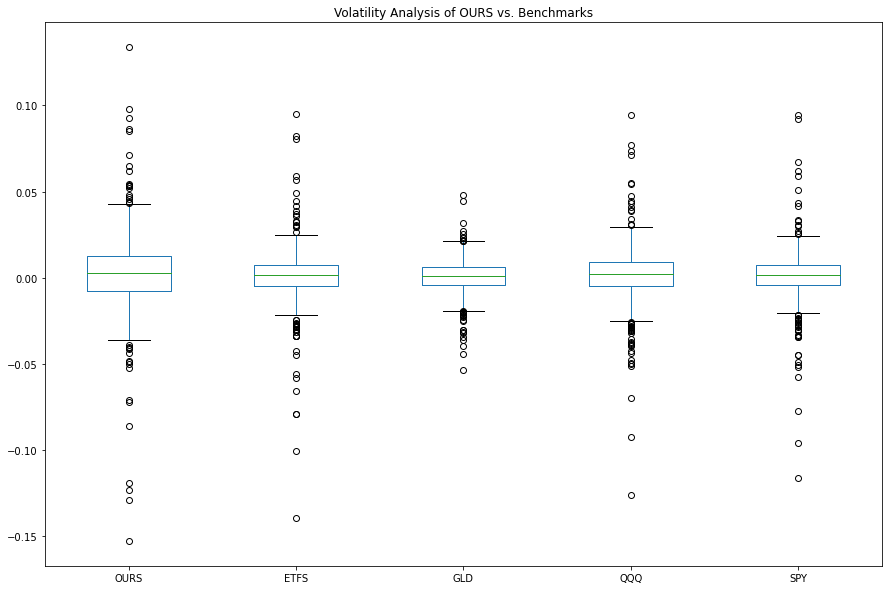

In [13]:
# Based on 2 year history
start_date = datetime.datetime(2019, 11, 5)
end_date = '2021-11-09'
# 1. Calculate daily return of 4 portfolios, our portfolio, ETF combined, SPY, QQQ
agg_daily_return_matrix = perf.get_combined_agg_daily_return(start_date, end_date, our_portfolio, etf_list_df, etf_benchmark_df)
agg_daily_return_matrix.plot(kind='box',figsize=(15,10),title='Volatility Analysis of OURS vs. Benchmarks')

<AxesSubplot:title={'center':'Cumulative Returns of OURS vs. Benchmarks'}, xlabel='date'>

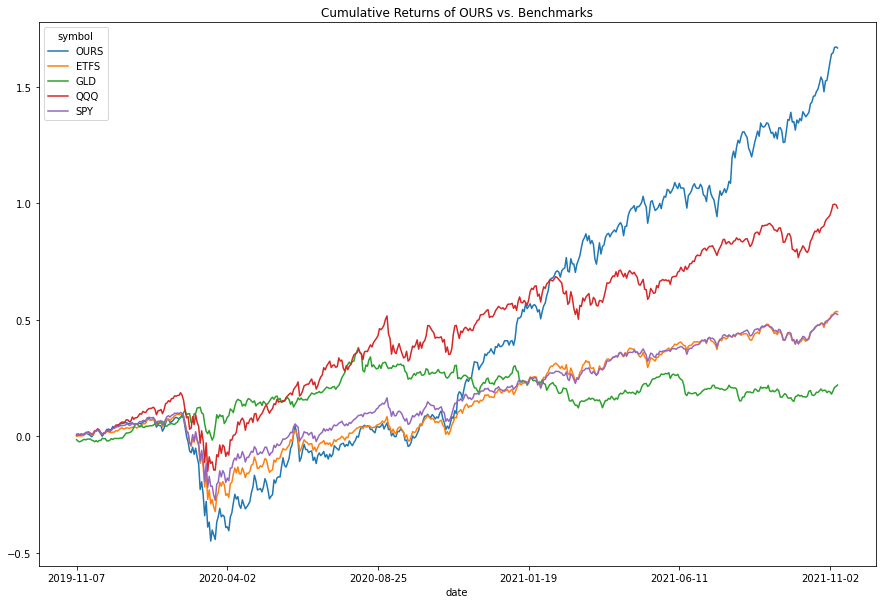

In [14]:
# 2. Calculate cumulative return of 4 portfolios
agg_cumulative_return_matrix = analytic.get_cumulative_return_matrix(agg_daily_return_matrix)
agg_cumulative_return_matrix

#Plot cumulative Return Chart
agg_cumulative_return_matrix.plot(figsize=(15,10), title="Cumulative Returns of OURS vs. Benchmarks")

<AxesSubplot:title={'center':'Rolling 30-Day Standard Deviation of Daily Returns - 4 OURS vs. Benchmarks'}, xlabel='date'>

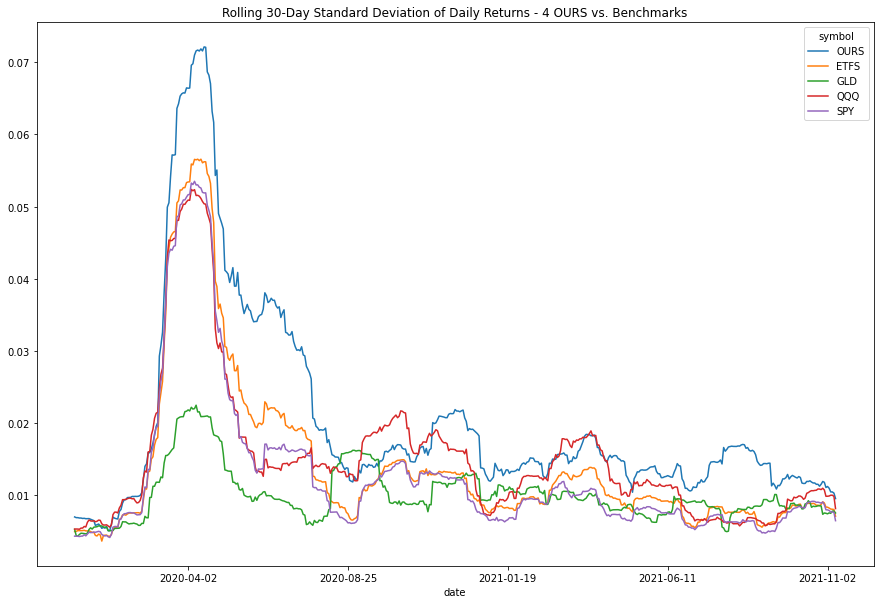

In [76]:
agg_daily_return_matrix.rolling(window=30).std().plot(figsize=(15,10), title='Rolling 30-Day Standard Deviation of Daily Returns - 4 OURS vs. Benchmarks')

In [77]:
agg_cumulative_return_matrix

symbol,OURS,ETFS,GLD,QQQ,SPY
date,,,,,
2019-11-07,0.007890,-0.000113,-0.015591,0.003404,0.003516
2019-11-08,0.008927,0.001052,-0.021926,0.007509,0.005958
2019-11-11,0.005893,0.001082,-0.024418,0.006058,0.004070
2019-11-12,0.007578,0.000506,-0.021570,0.008811,0.005861
2019-11-13,0.002342,0.002180,-0.017726,0.008110,0.006284
...,...,...,...,...,...
2021-11-03,1.640005,0.520282,0.180181,0.968636,0.513088
2021-11-04,1.644259,0.520602,0.193564,0.993692,0.520023
2021-11-05,1.668161,0.530816,0.208941,0.995344,0.525330


- As shown above charts, our portfolio is very volitile comparing benchmark portfolios ==>  riskier = higher return
- During past 2 years horizon, 1st one year(2019/11/07 - 2020/11/07) is underperform, then recent 1 year start out-performing and generating higher return 
  since we pick names based on the recent 1 year performance analysis

In [16]:
agg_performance_summary = perf.get_agg_portfolio_summary(agg_daily_return_matrix, year_trading_days, rolling_days)
agg_performance_summary

,Annualized_std_dev,Annualized_return,Sharpe_ratios,Beta to SP500
symbol,,,,
OURS,0.387413,0.564650,1.457489,1.275100
ETFS,0.280843,0.253239,0.901711,1.031540
GLD,0.167031,0.112754,0.675050,0.140768
QQQ,0.280404,0.379715,1.354171,1.128833
SPY,0.255632,0.242071,0.946948,1.000000


- Our Performance Summary: Sharpe Ratio: 1.46% and Beta to SP500: 1.275, even higher than 2nd outperformer - QQQ (Nasdaq 100) 

# STEP4. FORECAST PERFORMANCE -- MonteCarlo Simulation

In [18]:
# Convert 2YR AGG Daily Return into 100 Par-based Price into Conolidated Alpaca format to run MCForecast Tool
agg_daily_price_in_format = perf.get_agg_historical_prices(start_date, end_date, agg_daily_return_matrix, "OURS")
agg_daily_price_in_format

C:\programdata\anaconda3\envs\dev\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,OURS,ETFS,GLD,QQQ,SPY
,close,close,close,close,close
date,,,,,
2019-11-07 00:00:00-05:00,100.788989,99.988654,98.440948,100.340426,100.351631
2019-11-08 00:00:00-05:00,100.892707,100.105231,97.807361,100.750939,100.595819
2019-11-11 00:00:00-05:00,100.589324,100.108172,97.558197,100.605757,100.406981
2019-11-12 00:00:00-05:00,100.757798,100.050570,97.842956,100.881101,100.586052
2019-11-13 00:00:00-05:00,100.234222,100.218001,98.227380,100.811014,100.628378
...,...,...,...,...,...
2021-11-03 00:00:00-04:00,264.000512,152.028175,118.018082,196.863579,151.308849
2021-11-04 00:00:00-04:00,264.425869,152.060176,119.356446,199.369212,152.002344


In [20]:
# For Comparison, forecast 100% weight individually for next 10 years with 500 siumulations
ours_ten_years_simulation = MCSimulation(
    portfolio_data=agg_daily_price_in_format[["OURS"]],
    weights=[1.0],
    num_simulation=500,
    num_trading_days=252*10,
)

etf_ten_years_simulation = MCSimulation(
    portfolio_data=agg_daily_price_in_format[["ETFS"]],
    weights=[1.0],
    num_simulation=500,
    num_trading_days=252*10,
)

spy_ten_years_simulation = MCSimulation(
    portfolio_data=agg_daily_price_in_format[["SPY"]],
    weights=[1.0],
    num_simulation=500,
    num_trading_days=252*10,
)

qqq_ten_years_simulation = MCSimulation(
    portfolio_data=agg_daily_price_in_format[["QQQ"]],
    weights=[1.0],
    num_simulation=500,
    num_trading_days=252*10,
)

gld_ten_years_simulation = MCSimulation(
    portfolio_data=agg_daily_price_in_format[["GLD"]],
    weights=[1.0],
    num_simulation=500,
    num_trading_days=252*10,
)


In [21]:
ours_ten_years_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.985882,1.052355,1.011568,1.020907,0.988187,0.979329,1.028536,0.962291,1.000830,1.034462,...,1.001195,1.011497,1.010602,0.996425,0.997965,1.008308,0.993982,0.986129,1.032511,0.984099
2,1.027962,1.027862,1.000421,1.065760,0.973185,0.968270,1.066037,0.936860,0.961343,1.065326,...,1.017267,1.052933,1.038729,0.973377,1.041507,0.999094,1.012194,0.974412,1.030821,1.000071
3,1.005801,1.048451,0.960589,1.088957,0.925876,0.969345,1.057745,0.946637,0.996223,1.087189,...,1.023110,1.056145,1.052361,1.051876,1.016922,1.030289,0.999537,1.010914,1.013528,1.026561
4,0.985498,1.020338,0.978627,1.055000,0.907846,0.984084,1.089345,0.954161,0.996485,1.123635,...,0.989133,1.070703,1.062279,1.075120,1.002681,1.001952,1.002123,1.038988,1.060921,1.076979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1509.352533,349.038926,15.285391,116.342508,31.326783,146.836557,7.232896,501.242597,914.180971,26.206432,...,203.629864,260.992465,150.723870,170.629345,49.970735,38.334523,505.241018,42.369338,255.665227,457.235822
2517,1521.172073,348.016002,15.392896,115.976956,32.270830,140.635566,7.165063,492.983761,900.487760,26.352651,...,210.825730,260.868575,150.488520,166.123246,50.431716,39.097910,501.240483,43.127036,264.169769,458.662020
2518,1511.215746,351.539212,15.837931,116.694884,32.807519,142.474613,7.157444,491.338036,910.825763,26.275355,...,204.342604,259.266348,153.919535,171.446923,50.204319,36.755157,519.881147,43.913805,265.212383,476.744561
2519,1500.765933,346.049691,15.060663,114.760527,32.350789,142.638710,7.028066,491.323432,938.973426,26.116091,...,201.953814,251.193475,157.806899,166.858358,51.714228,37.139685,506.661992,42.392638,260.229549,465.945556


In [22]:
etf_ten_years_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006517,0.991219,1.002982,0.952702,1.002181,1.029419,0.998339,1.032944,1.003711,0.998079,...,1.017029,0.994821,1.007463,0.996293,1.009016,0.998975,0.989310,0.987002,1.008017,1.016911
2,1.038527,0.987927,1.003016,0.945925,0.982834,1.050327,1.002148,1.064454,1.017528,0.991618,...,0.972576,0.991097,0.985559,0.983202,0.981135,0.982219,0.976599,0.992745,1.004319,1.020403
3,1.025685,0.972173,1.015614,0.908568,0.990041,1.061585,0.999453,1.034110,1.006207,1.003613,...,1.007002,0.991336,0.980814,0.962648,0.958810,0.976427,0.981534,1.000943,1.027846,1.008688
4,1.011724,0.971380,1.022306,0.926760,0.967995,1.061952,0.998254,1.015888,1.017278,0.995036,...,1.025964,1.008937,0.937807,0.954896,0.953030,0.966143,0.986589,0.976007,1.015247,0.994584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,44.764594,12.006781,5.610955,4.696499,9.542134,8.872919,5.540571,19.042599,4.195080,8.572318,...,2.109421,1.036189,6.636829,5.832071,3.409197,0.960411,6.032403,10.776213,4.915226,7.738337
2517,44.177140,11.864306,5.638048,4.617137,9.320474,8.772177,5.786617,19.138798,4.179582,8.783233,...,2.112929,1.057440,6.664706,5.932986,3.483732,0.949152,6.065742,10.976087,4.907796,7.560363
2518,44.165032,11.971681,5.581677,4.597773,9.618470,8.549951,5.874106,19.805583,4.204193,8.780925,...,2.184504,1.080011,6.659479,5.862766,3.522293,0.931148,6.114394,11.045601,4.803025,7.279487
2519,44.280087,12.045274,5.526194,4.575469,9.434018,8.434079,6.084716,19.015054,4.247592,8.967619,...,2.164771,1.081468,6.604161,5.846419,3.616667,0.927235,5.983380,10.985399,4.849113,7.276291


In [23]:
spy_ten_years_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.013453,1.003420,0.996820,1.004184,0.990690,1.011106,0.977288,1.008877,0.986198,0.992354,...,1.010345,0.999056,1.018936,1.001151,1.006715,0.984134,0.983511,1.003006,0.999831,0.996417
2,1.002780,0.989802,0.969527,1.024355,1.006252,1.008876,0.966526,1.017597,0.991310,1.015570,...,1.002671,1.000385,1.010351,1.000674,0.979663,0.985417,1.010109,1.003154,0.985770,0.961121
3,0.965294,0.980589,1.004484,1.008783,1.003703,1.018452,0.968476,1.005418,1.012560,1.024800,...,1.038166,1.006925,1.041414,1.034078,0.988498,0.976204,0.996007,1.016830,0.966806,0.962838
4,0.951895,0.969767,1.010890,0.999886,1.023803,1.004226,0.971322,1.021812,1.020038,0.995102,...,1.035916,1.011941,1.007899,1.041257,0.990840,0.988407,1.022127,1.016534,0.949840,0.910971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,9.622082,22.538560,2.643851,10.447652,4.856813,8.772368,2.641976,4.295450,3.742354,8.121096,...,2.312694,35.807484,1.880506,18.608459,4.995129,5.873107,4.367101,31.469281,9.788295,5.435489
2517,9.566332,22.891923,2.662781,10.454184,4.846987,8.788751,2.674256,4.333251,3.620990,7.997753,...,2.297473,34.998779,1.887152,18.522859,4.902367,5.870022,4.415834,30.723917,9.955641,5.458970
2518,9.717146,23.425526,2.710571,10.378722,4.812232,8.665124,2.682406,4.341620,3.627840,7.872552,...,2.291376,35.548217,1.863852,18.171681,4.871131,5.910032,4.540757,30.997339,10.042239,5.441551
2519,9.878797,23.830519,2.668320,10.571219,4.814948,8.623428,2.684776,4.329530,3.590133,7.883707,...,2.269400,35.507540,1.873769,18.008068,4.832282,5.967252,4.614270,31.445211,10.212308,5.469351


In [24]:
qqq_ten_years_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.975722,1.002791,0.981232,1.005402,0.984317,0.992619,1.021065,0.990499,1.005566,0.958650,...,0.989484,1.017142,0.987228,1.027987,1.006313,1.000777,1.012205,1.018136,0.994763,0.989540
2,0.969959,1.016897,0.975882,0.998459,0.959105,0.999126,1.026689,1.020772,1.014265,0.942098,...,1.023806,0.988751,1.009295,1.031960,1.012276,1.012027,1.043783,1.047740,0.996213,1.030958
3,0.966790,1.012749,0.945163,0.965141,0.989948,1.003710,1.016169,1.020172,0.994908,0.941218,...,1.024057,0.967102,1.000855,1.040173,1.022054,1.013352,1.029673,1.027582,1.025676,1.018599
4,0.991142,1.013931,0.944576,0.993066,0.939475,1.007913,1.032672,0.988923,1.009554,0.905769,...,1.021361,1.000169,0.986586,1.023394,1.010588,0.986418,1.030738,1.067159,1.049434,1.004524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,215.395686,90.161115,29.137469,127.853164,34.718287,44.900976,27.310739,46.032451,24.353404,19.446014,...,45.683648,76.888838,6.913400,80.685110,16.870472,69.458715,21.415132,11.741722,25.853998,54.938875
2517,223.822475,87.525210,28.506227,131.246553,34.169136,47.123864,27.817870,46.059099,24.584054,19.968685,...,45.436352,79.156774,6.806294,83.531811,16.440685,69.609841,21.415745,11.855669,25.454415,54.471697
2518,222.095190,87.468610,27.738044,133.884481,33.729943,48.475626,27.291643,46.374612,24.308634,20.656629,...,45.261481,79.229175,6.789685,83.168302,16.340894,70.657356,21.158920,11.549029,25.754069,54.293599
2519,227.432624,87.942142,28.370296,139.209123,33.666060,48.311788,27.089553,47.714618,24.694682,21.343573,...,45.999742,80.786876,6.784538,84.174914,16.458300,69.040945,21.374964,11.442973,26.154555,53.811940


In [25]:
gld_ten_years_simulation.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001595,1.016433,1.001692,0.975697,1.013706,1.007323,1.001706,1.000259,0.996059,0.995025,...,1.007805,1.001107,0.991034,1.000262,1.004483,1.009578,0.998375,1.019163,1.003910,0.989542
2,1.008812,1.024273,1.001577,0.985106,1.030887,0.984178,0.995764,0.994899,0.999352,1.016768,...,1.015263,0.971857,0.988905,0.994189,1.011981,1.005634,0.998215,1.010484,1.016011,0.968188
3,1.004232,1.013299,1.016000,0.978372,1.031350,0.970758,0.998747,0.989107,1.001034,1.015955,...,1.004471,0.969966,0.987443,0.990631,0.982388,1.016213,1.017547,1.018160,1.020106,0.969121
4,0.993938,1.006344,1.026067,0.985911,1.030117,0.964512,1.003284,1.001371,1.016635,1.030568,...,1.003047,0.963331,0.973142,0.992630,0.981927,1.006011,1.022123,1.030837,1.018168,0.949431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,6.395466,1.515995,3.881281,1.263647,5.282626,3.447417,4.848774,1.748141,2.198546,4.074004,...,2.454623,1.553042,1.967134,3.771693,3.527244,1.423869,3.469812,1.823640,3.565040,2.328801
2517,6.377110,1.484668,3.867202,1.281140,5.237091,3.474950,4.827462,1.745765,2.190822,4.059432,...,2.417225,1.550801,1.944684,3.769617,3.489685,1.428288,3.467180,1.814398,3.574218,2.330997
2518,6.416564,1.453854,3.870858,1.292455,5.303458,3.489232,4.845101,1.761041,2.174276,4.070518,...,2.412528,1.553199,1.939961,3.743939,3.550240,1.453851,3.496085,1.838945,3.649024,2.332148
2519,6.387284,1.441833,3.814265,1.303938,5.343917,3.460188,4.811056,1.749214,2.150845,4.044505,...,2.400708,1.558547,1.934795,3.729684,3.540192,1.435855,3.459747,1.855284,3.621853,2.352896


<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

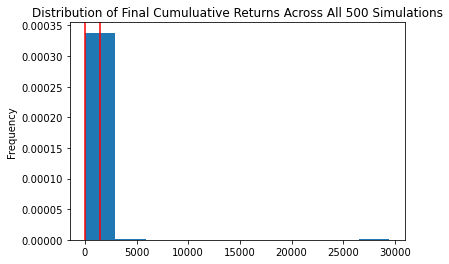

In [69]:
ours_ten_years_simulation.plot_distribution()

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

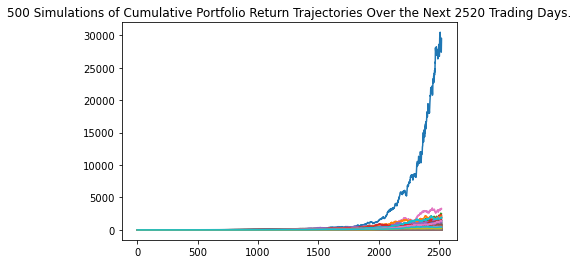

In [68]:
ours_ten_years_simulation.plot_simulation()

In [78]:
# Consolidate and Sumarize the 10-year Monte Carlo summary statistics (OURS vs. COMPS)
MC_forecast_10yr  = pd.DataFrame({'OURS':ours_ten_years_simulation.summarize_cumulative_return()})
MC_forecast_10yr = MC_forecast_10yr.join(pd.DataFrame({'ETFS':etf_ten_years_simulation.summarize_cumulative_return()}))
MC_forecast_10yr = MC_forecast_10yr.join(pd.DataFrame({'SPY':spy_ten_years_simulation.summarize_cumulative_return()}))
MC_forecast_10yr = MC_forecast_10yr.join(pd.DataFrame({'QQQ':qqq_ten_years_simulation.summarize_cumulative_return()}))
MC_forecast_10yr = MC_forecast_10yr.join(pd.DataFrame({'GLD':gld_ten_years_simulation.summarize_cumulative_return()}))
MC_forecast_10yr.iloc[8:10]

,OURS,ETFS,SPY,QQQ,GLD
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,315.347920,13.877895,11.721062,45.761956,3.229222
std,1356.086171,18.510605,16.870006,47.930563,1.841952
min,6.595019,0.308895,0.438375,1.860615,0.364852
25%,63.512742,5.267784,4.472366,16.853377,2.014422
50%,137.748396,9.245263,8.073615,30.659559,2.780318
75%,293.263871,16.226919,14.467639,55.124420,3.913972
max,29462.875530,297.671695,317.733387,506.160312,13.957448
95% CI Lower,13.817310,1.296673,1.612989,4.950681,1.021603
95% CI Upper,1420.212359,48.344110,39.240372,170.424122,8.282655


- based on MC 10 year simulation result: Our Portfolio is expected perform best among 5 comparisons based on MC simulation result:
There is a 95% chance that our portfolio over the 10 years will end within in the price upside potential range of 13.8% and 1420.21%
while 2nd best (QQQ) has 4.95% and 170.42%

# STEP5. FUTURE ENHANCEMENT AND IMPROVEMENT POINTS NOTE

- Need to conduct More Financial and Fundamental Analytics (such as PER, Revenue, Dividend) to pick better quality names for long-term investment  in addition to historical price return analytics
- Consider rebalancing and replacing names periodically to lower risk and maximize the return (also consider to do outside of short term tax investment period)
- Increase historical data range (currently, only limited to 2 years) and add more research data to conduct more in-depth analysis